In [1]:
import numpy as np
from tqdm import tqdm
from time import time
from PIL import Image

import torch
import torch.nn as nn

from IPython.display import clear_output
import matplotlib.pyplot as plt
%matplotlib inline

from archface import LResNet100
from get_sim_face_net import get_sim
from eigenfaces_privacy_pipeline import Pipeline

In [2]:
print(1)

1


In [3]:
class SymmetrifyView(nn.Module):
    def __init__(self, shape):
        super(SymmetrifyView,self).__init__()
        self.shape = shape
    def forward(self,x):
        out = x.view((-1,*self.shape))
        out += torch.flip(out, [3])
        out = out / 2
        
        return out

class Normalize(nn.Module):
    def forward(self, x):
        mean = x.mean(-1, keepdim=True)
        std = x.std(-1, keepdim=True)
        return (x - mean) / (std + 1e-6)
    
class MinMax(nn.Module):
    def forward(self, x):
        min = x.min(-1, keepdim=True).values
        x = x - min
        max = x.max(-1, keepdim=True).values
        x = x / max 
        return x
    
class View(nn.Module):
    def __init__(self, shape):
        super(View,self).__init__()
        self.shape = shape
    def forward(self,x):
        out = x.view((-1,*self.shape))
#         out += torch.flip(out, [3])
        return out

In [4]:
IMAGE = "./images/0.jpg" #"./images/lfw90.jpg" # face to be recovered

batch_size = 64
image_dim = 112

DEVICE = torch.device("cuda:4")
model = LResNet100().eval().to(DEVICE)
model.load_state_dict(torch.load("arcface.pt"))

eigenfaces = torch.load("eigenfaces.pt",map_location=DEVICE)
eigenfaces = nn.Sequential(eigenfaces,Normalize())
mean_face = 0

mean_face = torch.load("mean_face_rgb_full.pt") / 2




def preprocess_image_tensors(im):
    im = im - 0.5
    im = im * 2
    return im


im_target = torch.FloatTensor(np.transpose(np.array(Image.open(IMAGE)),(2,0,1))).to(DEVICE) / 255
im_target = nn.Upsample(size = (image_dim,image_dim))(im_target[None].to(DEVICE))

#embedding for face recovery (attacked embedding)
with torch.no_grad():
    emb_target = model(preprocess_image_tensors(im_target))
    

pipeline = Pipeline(emb_target,
                    model,
                    eigenfaces,
                    mean_face,
                    DEVICE,
                    dim=image_dim,
                    batch_size=batch_size,
                    multistart=10,
                    lr=0.005,
                    sigma=1,
                    downsample=False,
                    blur_before=None,#(5,1),#
                    blur_after=None,#(5,1),#None,#(7,1),#(7,1),#None,#(7,1),#
                    gray_scale=False
                    )

hyperparams: lr 0.005-0.001, sigma 1, color True, multistart 10

### Face recovery iterations

In [5]:
cosines_target = []
facenet_sims = []
iters = 0

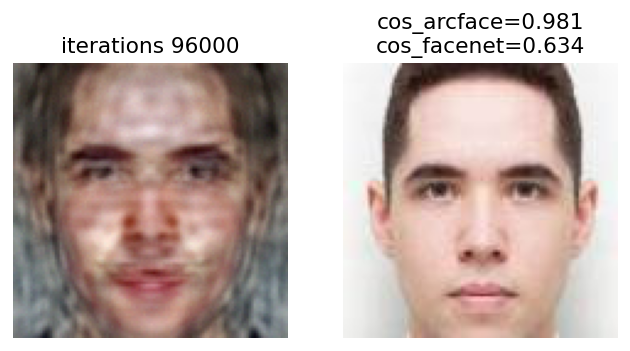

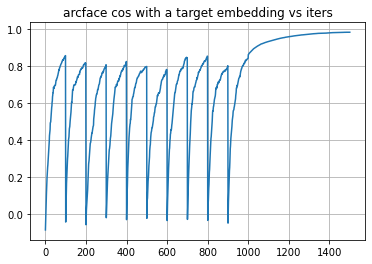

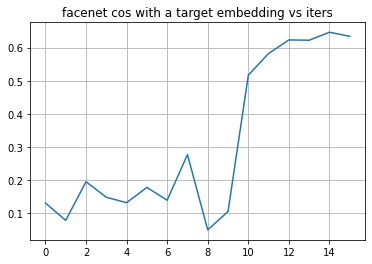

In [ ]:
with torch.no_grad():
    for _ in range(2001):
        start = time()
        if pipeline.iters >= pipeline.N_restarts * pipeline.iters_before_restart:
            pipeline.lr = 0.001
        recovered_face, cos_target = pipeline()
        cosines_target.append(cos_target)
        time_per_iter = round(time() - start,2)
        
        print(f"time={time_per_iter}    queries={iters*pipeline.batch_size}   cos_target={round(cos_target,3)}    \
        norm={round(pipeline.norm,4)}", end="\r")
        
        if iters % 100 == 0:
            clear_output(wait=True)
            face = np.transpose(recovered_face.cpu().detach().numpy(),(1,2,0))
            face = face - np.min(face)
            face = face / np.max(face)
            facenet_sims.append(get_sim(DEVICE,path1=IMAGE, im2=face))

            plt.figure(dpi=130)
            plt.subplot(1,2,1)
            plt.axis("off")
            plt.title(f"iterations {iters*pipeline.batch_size}")
            plt.imshow(face)
            plt.subplot(1,2,2)
            plt.axis("off")
            plt.title(f"cos_arcface={round(cos_target,3)}\ncos_facenet={round(facenet_sims[-1],3)}")
            plt.imshow(np.array(Image.open(IMAGE)))
            plt.show()

            plt.plot(cosines_target)
            plt.grid()
            plt.title("arcface cos with a target embedding vs iters")
            plt.show()
            
            plt.plot(facenet_sims)
            plt.grid()
            plt.title("facenet cos with a target embedding vs iters")
            plt.show()
            
        iters += 1